# Modèle EOLES

Traduction en python du modèle EOLES créé par Philippe Quirion.

Notebook pour simulation du modèle

- Import des données 
- Définition des paramètres autres (eta_in, eta_out, etc) 
- Création du modèle Pyomo pour optimiser la répartition du stockage quand les vre ne répondent pas à la demande
- Output: Génération heure par heure par chaque tecno dans un excel 
- Etat actuel: ne fonctionne pas, problèmes sur les contraintes -> toutes les valeurs de l'excel sont à 0. 

**Pour run:** soit le solveur cbc est installé sur jupyter et tout va bien / soit il est installé ailleurs (genre un terminal ubuntu par exemple) et ducoup faut download as .py et run à partir du terminal. 

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time
import sys
# Imports pour pyomo
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

import panel as pn 
from ipywidgets import interactive, interact_manual
import ipywidgets as widgets

#%matplotlib inline
pn.extension()


from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas


In [2]:
col = {"offshore" : '#1f4e79', "onshore" : '#548235' , "pv" : "#ffc000", "phs" : "#bdd7ee", "battery" : "#7030a0", "biogas" :"#843c0c", "methanation": "#7f6000", "gas": "grey", "lake": "#4169E1", "river" : "#09F1D3"}

## Import et Affichage des résultats de P.Quirion

## Coût des différentes technologies

In [3]:
scenarios = pd.read_csv("outputs/scenarios.csv", index_col="scen")
cost_decomposition = pd.read_csv("outputs/cost decomposition for all scenarios.csv", index_col="scen")

In [4]:
#scénario choisi 
scen = 157 
list(scenarios.iloc[scen][5:])

['central', 'central', 'central', 'central', 'central']

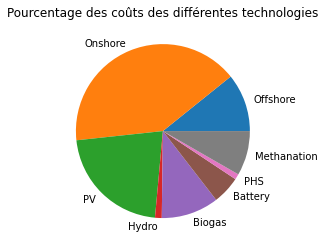

In [5]:
plt.figure()
plt.pie(list(map(lambda x: float(x[:-1]),list(cost_decomposition.iloc[scen]))), labels = ["Offshore","Onshore","PV","Hydro","Biogas","Battery","PHS","Methanation"])
plt.title("Pourcentage des coûts des différentes technologies")
plt.show()

### Résultats de l'optimisation 

In [6]:
scen2006 = pd.read_csv("outputs/real CF after internalization of LC/2006_LC_internalized.csv", index_col = "hour")
scen2006.columns = ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'gas', 'phs',
       'battery', 'methanation', 'Electricity demand', 'Storage phs', 'Storage battery', 'Storage methanation', 'Stored battery',
       'Stored phs', 'Stored methanation', 'elec_price', 'gas_price']
scen2006.head()

,offshore,onshore,pv,river,lake,biogas,gas,phs,battery,methanation,Electricity demand,Storage phs,Storage battery,Storage methanation,Stored battery,Stored phs,Stored methanation,elec_price,gas_price
hour,,,,,,,,,,,,,,,,,,,
0,10.93,40.80,0.0,1.27,0.0,0.0,0.0,0.00,0.0,0.0,28.69,-9.30,-7.35,-7.66,31.75,82.95,1813.37,0.0,0.0
1,0.00,42.09,0.0,1.30,0.0,0.0,0.0,0.00,0.0,0.0,31.21,-4.52,0.00,-7.66,38.37,91.78,1817.90,0.0,0.0
2,11.12,31.67,0.0,0.00,0.0,0.0,0.0,1.87,0.0,0.0,27.70,-9.30,0.00,-7.66,38.37,96.08,1822.42,0.0,0.0
3,0.00,43.18,0.0,1.12,0.0,0.0,0.0,0.00,0.0,0.0,27.99,-8.65,0.00,-7.66,38.37,102.84,1826.94,0.0,0.0
4,2.17,42.95,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,28.16,-9.30,0.00,-7.66,38.37,111.06,1831.46,0.0,0.0


In [7]:
# Sorties de l'opitimisation de P.Quirion

tec = ["offshore","onshore","pv","river","lake","biogas","phs","battery","methanation"]
stor = ["phs","methanation","battery"]

Volume_str_opti = pd.Series([180 , 15244.42, 92.32 ], index = stor)
S_opti = pd.Series([9.3,852,25.67], index = stor)
Q_tec_opti = pd.Series([16.95, 99.22, 115, 7.5, 12.86,21.25, 9.3, 25.67, 21.25], index = tec)


In [8]:
# Dashboard

def show(week,df):
    d = datasets[df]
    tec_aux = tec
    
    if not("river" in d.columns): tec_aux = list(set(tec_aux) - set(["river"]))
    if not("lake" in d.columns): tec_aux = list(set(tec_aux) - set(["lake"]))
    
    h  = 168*(week-1)+np.arange(1,169)
    ymin, ymax = -45,130
    h_ratio = np.ones(len(stor)+1)
    h_ratio[0] = 2 # 1er subplot 2 fois plus grand
    fig, axs = plt.subplots(len(stor)+1, figsize = (15,15),gridspec_kw={'height_ratios':h_ratio})
    
    # Stockage 
    sum_s = 0
    for i in stor: 
        sum_s += d["Storage " + i][h]
    for s in stor[::-1]:
        aux = "Storage " + s
        axs[0].fill_between(h, sum_s, color = col[s], label = aux)
        sum_s -= d[aux][h]

    # Production
    sum_g = 0
    for i in tec_aux: 
        sum_g += d[i][h]
    for gene in tec_aux[::-1]: 
        axs[0].fill_between(h,sum_g, color = col[gene], label = gene )
        sum_g -= d[gene][h]
    
    # Demande
    axs[0].plot(h, d["Electricity demand"][h], color = 'r' , label = "Demand",linewidth= 4)

    axs[0].vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    #axs[0].set_xlabel("Heure (h)")
    axs[0].set_ylabel("Production (GWh)")
    axs[0].set_ylim(ymin,ymax)
    #axs[0].set_xlim(h[0], h[-1]+70)
    axs[0].legend(loc ="upper right")
    axs[0].set_title("Semaine "+ str(week))
    
    if df == "Scénario 2006": 
        Volume = Volume_str_opti
    else: 
        Volume = Volume_str
        
    for s in range(0,len(stor)):
        axs[s+1].fill_between(h, d["Stored " + stor[s]][h], color = col[stor[s]])
        axs[s+1].hlines(y=Volume[s], xmin = h[0], xmax = h[-1], label = "limit", color = 'red')
        axs[s+1].set_title("Stored " + str(stor[s]))
        axs[s+1].vlines(x=np.linspace(h[0],h[-1],8),ymin = 0, ymax = Volume[s]+10,colors="black",linestyle='dotted',linewidth=2)
        

datasets = {"Scénario 2006" : scen2006}
interactive_plot = interact_manual(show, week=widgets.IntText(value = 1), df = datasets.keys())
interactive_plot

interactive(children=(IntText(value=1, description='week'), Dropdown(description='df', options=('Scénario 2006…

<function __main__.show(week, df)>

## Choix de Q, S et VOLUME

In [9]:
# Choix intéractif des variables

Volume_phs = widgets.FloatSlider(min=0, max=Volume_str_opti["phs"]*5, step=0.01, description='Volume phs',value = Volume_str_opti["phs"])
Volume_methanation = widgets.FloatSlider(min=0, max=Volume_str_opti["methanation"]*5, step=0.01, description='Volume methanation',value = Volume_str_opti["methanation"])
Volume_battery =  widgets.FloatSlider(min=0, max=Volume_str_opti["battery"]*5, step=0.01, description='Volume battery',value = Volume_str_opti["battery"])
  

Q_offshore= widgets.FloatSlider(min=0, max=Q_tec_opti["offshore"]*5, step=0.01, description='Q offshore',value = Q_tec_opti["offshore"])
Q_onshore= widgets.FloatSlider(min=0, max=Q_tec_opti["onshore"]*5, step=0.01, description='Q onshore',value = Q_tec_opti["onshore"])
Q_pv= widgets.FloatSlider(min=0, max=Q_tec_opti["pv"]*5, step=0.1, description='Q pv',value = Q_tec_opti["pv"])
Q_river= widgets.FloatSlider(min=0, max=Q_tec_opti["river"]*5, step=0.01, description='Q river',value = Q_tec_opti["river"])
Q_lake= widgets.FloatSlider(min=0, max=Q_tec_opti["lake"]*5, step=0.01, description='Q lake',value = Q_tec_opti["lake"])
Q_biogas= widgets.FloatSlider(min=0, max=Q_tec_opti["biogas"]*5, step=0.01, description='Q biogas',value = Q_tec_opti["biogas"])
Q_phs= widgets.FloatSlider(min=0, max=Q_tec_opti["phs"]*5, step=0.01, description='Q phs',value = Q_tec_opti["phs"])
Q_battery= widgets.FloatSlider(min=0, max=Q_tec_opti["battery"]*5, step=0.01, description='Q battery',value = Q_tec_opti["battery"])
Q_methanation= widgets.FloatSlider(min=0, max=Q_tec_opti["methanation"]*5, step=0.01, description='Q methanation',value = Q_tec_opti["methanation"])


S_methanation = widgets.FloatSlider(min=0, max=S_opti["methanation"]*5, step=0.01, description='S methanation',value = S_opti["methanation"])

widgets.HBox([widgets.VBox([Q_offshore, Q_onshore, Q_pv, Q_river, Q_lake,Q_biogas ,Q_phs,Q_battery,Q_methanation]),
widgets.VBox([Volume_phs,Volume_battery,Volume_methanation]), S_methanation])


In [17]:
# Mise en forme des variables

Q_tec = [Q_offshore.value, Q_onshore.value, Q_pv.value, Q_river.value, Q_lake.value,Q_biogas.value ,Q_phs.value,Q_battery.value,Q_methanation.value]
Volume_str = [Volume_phs.value,Volume_methanation.value,Volume_battery.value]
S =  [Q_phs.value,S_methanation.value,Q_battery.value]

# Capacity in GW Q
Q_tec = pd.Series( Q_tec, index = tec)

# si river ou lake sont à 0, on les rétire de Q
if Q_tec["river"] == 0 : del Q_tec["river"]
if Q_tec["lake"] == 0 : del Q_tec["lake"]
    
# Energy volume of storage technology in GWh VOLUME
Volume_str =pd.Series(Volume_str, index = stor)

#Storage charging power S
S =pd.Series(S, index = stor)


print("--- Valeurs fixées : ---")
print("Q : ", Q_tec)
print("VOLUME : ", Volume_str)
print("S : ", S)

--- Valeurs fixées : ---
Q :  offshore        60.14
onshore        347.27
pv               0.00
river            7.50
lake            12.86
biogas          21.25
phs             37.43
battery         25.67
methanation     21.25
dtype: float64
VOLUME :  phs              731.61
methanation    15244.42
battery           92.32
dtype: float64
S :  phs             37.43
methanation    852.00
battery         25.67
dtype: float64


# Simulation du modèle

In [18]:
from modeles import modele

simu1 = modele(Q_tec, Volume_str, S)
simu1.load_param("inputs/")
simu1.init_set()
simu1.init_variable()
simu1.add_constraints()
simu1.optimisation()
res = simu1.write_results("simu1")


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Ecriture des résultats ...
Simulation du modèle faite avec succès ! 


In [19]:
res.head()

,hour,offshore,onshore,pv,river,lake,biogas,phs,battery,methanation,Storage phs,Storage battery,Storage methanation,Stored phs,Stored battery,Stored methanation,reserve phs,reserve battery,reserve lake,Electricity demand
0,0,52.03,177.70,0.0,1.27,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.00,11.32,0.00,28.69
1,1,52.92,183.33,0.0,1.30,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,11.34,0.00,0.00,31.21
2,2,52.92,186.82,0.0,1.11,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.00,11.30,0.00,27.70
3,3,52.53,188.07,0.0,1.12,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.00,0.00,11.31,27.99
4,4,51.24,187.09,0.0,1.21,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.00,11.31,0.00,28.16


In [13]:
print("Coûts", simu1.cost())

Coûts    COST (billion euros)  Cost per MWh produced (euros/MWh)
0         143039.587119                       247387.26789


In [20]:
# Dictionnaire datasets pour affichage intéractif (charger dataframe nécessaires)
datasets["Modèle n°1" ] = res

# Dashboard
interactive_plot = interact_manual(show, week=widgets.IntText(value = 1), df = datasets.keys())
interactive_plot

interactive(children=(IntText(value=1, description='week'), Dropdown(description='df', options=('Scénario 2006…

<function __main__.show(week, df)>